In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

!pip install optuna
!pip install timm
!pip install scikit-learn
!pip install pandas
!pip install seaborn

torch version: 1.13.1
torchvision version: 0.14.1


In [2]:
# Continue with regular imports
!pip install matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
!pip install ipython-autotime
%load_ext autotime

time: 406 µs (started: 2023-05-12 15:46:29 +00:00)


Load and preprocess the data

In [ ]:
#unzip the data that we had split earlier before in the preprocessing notebook, to ensure that the same data is used
!unzip /isic2019-dataset.zip

In [4]:
from torchvision.transforms import Compose, CenterCrop, Normalize, Resize, ToTensor
from torchvision.transforms import InterpolationMode
from torchvision.transforms import RandAugment

# Set the random seed for reproducibility
torch.manual_seed(42)

# Define the transformation parameters
resize_size = [224, 224]
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
interpolation = InterpolationMode.BICUBIC

# Define the data augmentation transformation pipeline for the training set.
#the specific data augmentation technique that will be applied is called RandAugment. 
randaug_transform = Compose([
    Resize(resize_size, interpolation=interpolation),
    transforms.CenterCrop(size=224),
    RandAugment(num_ops=3, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None),
    ToTensor(),
    Normalize(mean=mean, std=std)
])

#define the transformation function that will be used to pre-process the data in the imagefolder function from Pytorch for the validation and test set 
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC), #resize the image to 224 by 224
    transforms.CenterCrop(size=224), # apply centercrop
    transforms.ToTensor(), #converts the image from a PIL Image object to a PyTorch tensor.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #normalizes the tensor image
])


time: 3.26 ms (started: 2023-05-07 12:35:30 +00:00)


Hyperparameter tuning: We used optuna hyperparameter optimization framework and defined the train and validation set and the MaxViT model within this function. The validation set was used to tune the hyperparameters. 

In [5]:
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import optuna
import timm
import torch.utils.data.sampler as sampler
from torch.utils.data import Subset
from torch.utils.data.sampler import RandomSampler
import torchvision.datasets as datasets
from sklearn import metrics
from sklearn.metrics import f1_score

# Set the random seed for reproducibility
torch.manual_seed(42)

# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

#define hyperparameter tuning, furthermore we will use 
#10 trials to look for the best hyperparameters. We re-used the optuna hyperparamete optimization code 
#the code that was re-used is available at: https://github.com/optuna/optuna

# Define the dataset and dataloader
def get_data_loaders(batch_size):

# Load and transform the data

    # Load the datasets
    train_dataset = datasets.ImageFolder(root='data/train', transform=randaug_transform)
    val_dataset = datasets.ImageFolder(root='data/valid', transform=transform)

    # load the data and shuffle the training data
    train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    valid_dataloader = data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    return train_dataloader, valid_dataloader

def get_model(trial, dropout, num_hidden_layers, num_neurons):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_name = 'repvgg_b3'
    model = timm.create_model(model_name, pretrained=True, num_classes=8)

    num_in_features = model.get_classifier().in_features

    # Define the classification head with the number of neurons and hidden layers to optimize
    classifier_layers = []
    for i in range(num_hidden_layers):
        if i == 0:
            in_features = num_in_features
            out_features = num_neurons
        else:
            in_features = num_neurons
            out_features = num_neurons
        classifier_layers.extend([
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.Dropout(p=dropout),
        ])
    classifier_layers.append(nn.Linear(num_neurons, 8))
    model.head.fc = nn.Sequential(*classifier_layers)

    # Freeze the weights
    for param in model.parameters():
        param.requires_grad = False
   
    # Unfreeze the classifierhead layer 
    for param in model.head.parameters():
        param.requires_grad = True

    return model

# Define the objective function for Optuna
def objective(trial):
    # Get the hyperparameters to optimize
    batch_size = 32  # set batch size to 32
    epochs = 20  # set epochs to 20
    num_epochs = 20
    optimizer_name = trial.suggest_categorical("optimizer_name", ["AdamW", "SGD"])
    weight_decay = trial.suggest_float("weight_decay", low=0.001, high=0.01, log=True)
    learning_rate = trial.suggest_float("learning_rate", low=0.001, high=0.01, log=True)
    dropout = trial.suggest_categorical("dropout", [0.25,0.5])
    num_hidden_layers = trial.suggest_int("num_hidden_layers", low=1, high=2)
    num_neurons = trial.suggest_categorical("num_neurons", [256, 512])

    # Get the data loaders
    train_dataloader, valid_dataloader = get_data_loaders(batch_size)

    # Get the model
    model = get_model(trial, dropout, num_hidden_layers, num_neurons)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Define the optimizer and loss function
    if optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

# Initialize variables for early stopping
    best_accuracy = 0.0
    best_val_loss = float('inf')
    best_f1_score = 0.0
    patience = 3
    no_improvement_count = 0

   # Train the model
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        running_total = 0
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                scaler.scale(loss).backward()    # Scale the gradients
                scaler.step(optimizer)           # Update the model parameters
                scaler.update()                  # Update the scaler

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            running_total += labels.size(0)
            running_corrects += (predicted == labels).sum().item()

        # Calculate the training loss and training accuracy
        train_loss = running_loss / len(train_dataloader.dataset)
        train_accuracy = 100 * running_corrects / running_total

        # evaluate on the validation set
        correct = 0
        total = 0
        val_loss = 0.0
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for data in valid_dataloader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item() * labels.size(0)

                y_true += labels.cpu().tolist()
                y_pred += predicted.cpu().tolist()

        # Calculate the validation accuracy and validation loss
        accuracy = 100 * correct / total
        val_loss /= len(valid_dataloader.dataset)

        #calculate the macro f1-score
        f1_score = metrics.f1_score(y_true, y_pred, average='macro')

        # Print the accuracy, validation loss, and f1-score
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%, Validation Loss = {val_loss:.4f}, Validation Accuracy = {accuracy:.2f}%, F1-score = {f1_score:.4f}")

        # Report the intermediate result
        trial.report(f1_score, epoch)

        # Check if the validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Check if the f1 score has improved
        if f1_score > best_f1_score:
            best_f1_score = f1_score

        # Check if early stopping criteria has been met
        if no_improvement_count >= patience:
            print(f"No improvement after {no_improvement_count} epochs. Stopping training...")
            break

    return best_f1_score

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-05-07 12:35:32,062] A new study created in memory with name: no-name-03db1de9-4931-457c-bbd7-2288888c69a2
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-repvgg-weights/repvgg_b3-199bc50d.pth" to /root/.cache/torch/hub/checkpoints/repvgg_b3-199bc50d.pth


Epoch 1: Train Loss = 1.3373, Train Accuracy = 56.47%, Validation Loss = 1.0186, Validation Accuracy = 63.43%, F1-score = 0.2685
Epoch 2: Train Loss = 0.9932, Train Accuracy = 64.35%, Validation Loss = 0.8983, Validation Accuracy = 67.24%, F1-score = 0.3979
Epoch 3: Train Loss = 0.9483, Train Accuracy = 65.09%, Validation Loss = 0.9046, Validation Accuracy = 67.01%, F1-score = 0.3964
Epoch 4: Train Loss = 0.9280, Train Accuracy = 66.60%, Validation Loss = 0.8647, Validation Accuracy = 68.74%, F1-score = 0.3928
Epoch 5: Train Loss = 0.9158, Train Accuracy = 66.91%, Validation Loss = 0.8712, Validation Accuracy = 67.52%, F1-score = 0.3828
Epoch 6: Train Loss = 0.9013, Train Accuracy = 67.09%, Validation Loss = 0.8685, Validation Accuracy = 68.26%, F1-score = 0.3892
Epoch 7: Train Loss = 0.9093, Train Accuracy = 67.14%, Validation Loss = 0.8542, Validation Accuracy = 68.93%, F1-score = 0.4059
Epoch 8: Train Loss = 0.8925, Train Accuracy = 67.67%, Validation Loss = 0.8616, Validation Accur

[I 2023-05-07 12:58:00,195] Trial 0 finished with value: 0.40585285949864414 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.004207237536277546, 'learning_rate': 0.0039104168213715046, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 512}. Best is trial 0 with value: 0.40585285949864414.


Epoch 10: Train Loss = 0.8996, Train Accuracy = 67.37%, Validation Loss = 0.8557, Validation Accuracy = 68.62%, F1-score = 0.3829
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.3194, Train Accuracy = 56.98%, Validation Loss = 0.9704, Validation Accuracy = 64.57%, F1-score = 0.3472
Epoch 2: Train Loss = 0.9966, Train Accuracy = 64.40%, Validation Loss = 0.8987, Validation Accuracy = 67.56%, F1-score = 0.3827
Epoch 3: Train Loss = 0.9472, Train Accuracy = 65.76%, Validation Loss = 0.8812, Validation Accuracy = 67.32%, F1-score = 0.3828
Epoch 4: Train Loss = 0.9253, Train Accuracy = 66.17%, Validation Loss = 0.8610, Validation Accuracy = 67.95%, F1-score = 0.4113
Epoch 5: Train Loss = 0.9148, Train Accuracy = 66.52%, Validation Loss = 0.8807, Validation Accuracy = 67.24%, F1-score = 0.4037
Epoch 6: Train Loss = 0.9027, Train Accuracy = 67.08%, Validation Loss = 0.8569, Validation Accuracy = 67.95%, F1-score = 0.3864
Epoch 7: Train Loss = 0.8965, Train Accuracy

[I 2023-05-07 13:20:27,089] Trial 1 finished with value: 0.4244973834489283 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.00467350010562625, 'learning_rate': 0.004776457662316963, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 1 with value: 0.4244973834489283.


Epoch 10: Train Loss = 0.8909, Train Accuracy = 67.35%, Validation Loss = 0.8718, Validation Accuracy = 67.32%, F1-score = 0.4222
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2472, Train Accuracy = 57.75%, Validation Loss = 0.9893, Validation Accuracy = 64.89%, F1-score = 0.2984
Epoch 2: Train Loss = 1.0129, Train Accuracy = 63.89%, Validation Loss = 0.9111, Validation Accuracy = 66.73%, F1-score = 0.3623
Epoch 3: Train Loss = 0.9727, Train Accuracy = 64.86%, Validation Loss = 0.8960, Validation Accuracy = 67.91%, F1-score = 0.3549
Epoch 4: Train Loss = 0.9516, Train Accuracy = 65.75%, Validation Loss = 0.8808, Validation Accuracy = 68.15%, F1-score = 0.4440
Epoch 5: Train Loss = 0.9481, Train Accuracy = 65.70%, Validation Loss = 0.8775, Validation Accuracy = 67.79%, F1-score = 0.4329
Epoch 6: Train Loss = 0.9251, Train Accuracy = 66.50%, Validation Loss = 0.8910, Validation Accuracy = 67.12%, F1-score = 0.3896
Epoch 7: Train Loss = 0.9163, Train Accuracy

[I 2023-05-07 13:54:17,187] Trial 2 finished with value: 0.49522892424101883 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.003654258022728829, 'learning_rate': 0.003056146144347022, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 512}. Best is trial 2 with value: 0.49522892424101883.


Epoch 15: Train Loss = 0.8591, Train Accuracy = 68.84%, Validation Loss = 0.8456, Validation Accuracy = 69.01%, F1-score = 0.4952
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2337, Train Accuracy = 59.21%, Validation Loss = 0.9835, Validation Accuracy = 65.79%, F1-score = 0.3857
Epoch 2: Train Loss = 0.9760, Train Accuracy = 64.80%, Validation Loss = 0.8958, Validation Accuracy = 67.09%, F1-score = 0.3631
Epoch 3: Train Loss = 0.9432, Train Accuracy = 65.81%, Validation Loss = 0.8943, Validation Accuracy = 67.28%, F1-score = 0.3652
Epoch 4: Train Loss = 0.9322, Train Accuracy = 66.12%, Validation Loss = 0.8793, Validation Accuracy = 68.22%, F1-score = 0.4179
Epoch 5: Train Loss = 0.9301, Train Accuracy = 66.35%, Validation Loss = 0.8857, Validation Accuracy = 68.03%, F1-score = 0.3787
Epoch 6: Train Loss = 0.9227, Train Accuracy = 66.69%, Validation Loss = 0.8784, Validation Accuracy = 67.67%, F1-score = 0.3741
Epoch 7: Train Loss = 0.9192, Train Accuracy

[I 2023-05-07 14:23:58,866] Trial 3 finished with value: 0.4179038218130417 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.009745972370919046, 'learning_rate': 0.0037295331744750357, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 256}. Best is trial 2 with value: 0.49522892424101883.


Epoch 13: Train Loss = 0.9207, Train Accuracy = 66.68%, Validation Loss = 0.8793, Validation Accuracy = 68.11%, F1-score = 0.4009
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2836, Train Accuracy = 56.87%, Validation Loss = 0.9783, Validation Accuracy = 64.26%, F1-score = 0.2873
Epoch 2: Train Loss = 0.9916, Train Accuracy = 64.70%, Validation Loss = 0.9142, Validation Accuracy = 67.20%, F1-score = 0.4089
Epoch 3: Train Loss = 0.9394, Train Accuracy = 66.03%, Validation Loss = 0.8863, Validation Accuracy = 67.32%, F1-score = 0.3779
Epoch 4: Train Loss = 0.9338, Train Accuracy = 66.31%, Validation Loss = 0.8815, Validation Accuracy = 66.65%, F1-score = 0.3327
Epoch 5: Train Loss = 0.9287, Train Accuracy = 66.50%, Validation Loss = 0.8763, Validation Accuracy = 67.91%, F1-score = 0.4029
Epoch 6: Train Loss = 0.9196, Train Accuracy = 66.82%, Validation Loss = 0.8813, Validation Accuracy = 66.85%, F1-score = 0.3595
Epoch 7: Train Loss = 0.9174, Train Accuracy

[I 2023-05-07 15:09:36,435] Trial 4 finished with value: 0.4157904347040066 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0031760200342455147, 'learning_rate': 0.00871678236692318, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 2 with value: 0.49522892424101883.


Epoch 17: Train Loss = 0.9059, Train Accuracy = 66.91%, Validation Loss = 0.8638, Validation Accuracy = 68.62%, F1-score = 0.4158
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.1479, Train Accuracy = 59.71%, Validation Loss = 0.9561, Validation Accuracy = 65.44%, F1-score = 0.3356
Epoch 2: Train Loss = 0.9909, Train Accuracy = 64.24%, Validation Loss = 0.9219, Validation Accuracy = 66.89%, F1-score = 0.3660
Epoch 3: Train Loss = 0.9523, Train Accuracy = 65.66%, Validation Loss = 0.8840, Validation Accuracy = 67.20%, F1-score = 0.3947
Epoch 4: Train Loss = 0.9425, Train Accuracy = 65.95%, Validation Loss = 0.8741, Validation Accuracy = 68.85%, F1-score = 0.4846
Epoch 5: Train Loss = 0.9238, Train Accuracy = 66.51%, Validation Loss = 0.9031, Validation Accuracy = 67.87%, F1-score = 0.4149
Epoch 6: Train Loss = 0.9103, Train Accuracy = 66.98%, Validation Loss = 0.8771, Validation Accuracy = 67.79%, F1-score = 0.4000


[I 2023-05-07 15:26:24,242] Trial 5 finished with value: 0.48455587517428966 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0023915918275062924, 'learning_rate': 0.007040208402223771, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 256}. Best is trial 2 with value: 0.49522892424101883.


Epoch 7: Train Loss = 0.9148, Train Accuracy = 66.94%, Validation Loss = 0.8952, Validation Accuracy = 66.97%, F1-score = 0.4452
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.3067, Train Accuracy = 57.33%, Validation Loss = 0.9772, Validation Accuracy = 65.24%, F1-score = 0.2999
Epoch 2: Train Loss = 0.9864, Train Accuracy = 64.84%, Validation Loss = 0.8996, Validation Accuracy = 67.01%, F1-score = 0.3348
Epoch 3: Train Loss = 0.9419, Train Accuracy = 65.81%, Validation Loss = 0.8768, Validation Accuracy = 68.34%, F1-score = 0.4030
Epoch 4: Train Loss = 0.9180, Train Accuracy = 66.62%, Validation Loss = 0.8633, Validation Accuracy = 67.91%, F1-score = 0.3989
Epoch 5: Train Loss = 0.9128, Train Accuracy = 66.79%, Validation Loss = 0.8704, Validation Accuracy = 67.28%, F1-score = 0.3768
Epoch 6: Train Loss = 0.8984, Train Accuracy = 67.22%, Validation Loss = 0.8492, Validation Accuracy = 68.85%, F1-score = 0.4068
Epoch 7: Train Loss = 0.8914, Train Accuracy 

[I 2023-05-07 16:00:29,773] Trial 6 finished with value: 0.47695266318059026 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0033735089696419, 'learning_rate': 0.002082545145569372, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 2 with value: 0.49522892424101883.


Epoch 17: Train Loss = 0.8560, Train Accuracy = 68.28%, Validation Loss = 0.8454, Validation Accuracy = 68.66%, F1-score = 0.4498
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.1978, Train Accuracy = 58.90%, Validation Loss = 0.9443, Validation Accuracy = 65.95%, F1-score = 0.3291
Epoch 2: Train Loss = 0.9929, Train Accuracy = 64.43%, Validation Loss = 0.9620, Validation Accuracy = 64.89%, F1-score = 0.3481
Epoch 3: Train Loss = 0.9580, Train Accuracy = 65.39%, Validation Loss = 0.9167, Validation Accuracy = 66.58%, F1-score = 0.3419
Epoch 4: Train Loss = 0.9400, Train Accuracy = 65.99%, Validation Loss = 0.8831, Validation Accuracy = 68.38%, F1-score = 0.4165
Epoch 5: Train Loss = 0.9314, Train Accuracy = 66.19%, Validation Loss = 0.8861, Validation Accuracy = 67.52%, F1-score = 0.4209
Epoch 6: Train Loss = 0.9241, Train Accuracy = 66.35%, Validation Loss = 0.8974, Validation Accuracy = 67.32%, F1-score = 0.4508
Epoch 7: Train Loss = 0.9087, Train Accuracy

[I 2023-05-07 16:32:10,029] Trial 7 finished with value: 0.4817913649185314 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.00363980954515318, 'learning_rate': 0.00609377129425907, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 2 with value: 0.49522892424101883.


Epoch 16: Train Loss = 0.8669, Train Accuracy = 67.91%, Validation Loss = 0.8445, Validation Accuracy = 70.35%, F1-score = 0.4818
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2204, Train Accuracy = 58.98%, Validation Loss = 0.9766, Validation Accuracy = 64.30%, F1-score = 0.3730
Epoch 2: Train Loss = 1.0061, Train Accuracy = 63.84%, Validation Loss = 0.9300, Validation Accuracy = 65.63%, F1-score = 0.4198
Epoch 3: Train Loss = 0.9624, Train Accuracy = 64.94%, Validation Loss = 0.8790, Validation Accuracy = 68.15%, F1-score = 0.4875
Epoch 4: Train Loss = 0.9327, Train Accuracy = 66.13%, Validation Loss = 0.9066, Validation Accuracy = 67.20%, F1-score = 0.4424
Epoch 5: Train Loss = 0.9283, Train Accuracy = 66.23%, Validation Loss = 0.8530, Validation Accuracy = 69.09%, F1-score = 0.4442
Epoch 6: Train Loss = 0.9083, Train Accuracy = 67.09%, Validation Loss = 0.8538, Validation Accuracy = 68.66%, F1-score = 0.4263
Epoch 7: Train Loss = 0.8998, Train Accuracy

[I 2023-05-07 17:02:03,327] Trial 8 finished with value: 0.5155745064052797 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.002691190964084814, 'learning_rate': 0.0027759020319904943, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 8 with value: 0.5155745064052797.


Epoch 15: Train Loss = 0.8533, Train Accuracy = 68.89%, Validation Loss = 0.8558, Validation Accuracy = 68.70%, F1-score = 0.5156
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.3382, Train Accuracy = 57.70%, Validation Loss = 1.0259, Validation Accuracy = 65.87%, F1-score = 0.3854
Epoch 2: Train Loss = 0.9736, Train Accuracy = 65.07%, Validation Loss = 0.8883, Validation Accuracy = 67.71%, F1-score = 0.4069
Epoch 3: Train Loss = 0.9344, Train Accuracy = 66.38%, Validation Loss = 0.8778, Validation Accuracy = 67.95%, F1-score = 0.4214
Epoch 4: Train Loss = 0.9213, Train Accuracy = 66.25%, Validation Loss = 0.8469, Validation Accuracy = 68.97%, F1-score = 0.4315
Epoch 5: Train Loss = 0.9049, Train Accuracy = 66.94%, Validation Loss = 0.8517, Validation Accuracy = 68.66%, F1-score = 0.4358
Epoch 6: Train Loss = 0.8924, Train Accuracy = 67.46%, Validation Loss = 0.8616, Validation Accuracy = 68.26%, F1-score = 0.4418


[I 2023-05-07 17:15:18,290] Trial 9 finished with value: 0.4417860648257085 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.00650492756217381, 'learning_rate': 0.0014304376828661461, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 8 with value: 0.5155745064052797.


Epoch 7: Train Loss = 0.8803, Train Accuracy = 67.73%, Validation Loss = 0.8558, Validation Accuracy = 68.50%, F1-score = 0.4369
No improvement after 3 epochs. Stopping training...
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  0
  Number of complete trials:  10
Best trial:
  Value:  0.5155745064052797
  Params: 
    optimizer_name: AdamW
    weight_decay: 0.002691190964084814
    learning_rate: 0.0027759020319904943
    dropout: 0.5
    num_hidden_layers: 1
    num_neurons: 512
time: 4h 39min 46s (started: 2023-05-07 12:35:31 +00:00)


/tmp/ipykernel_463/3515757420.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

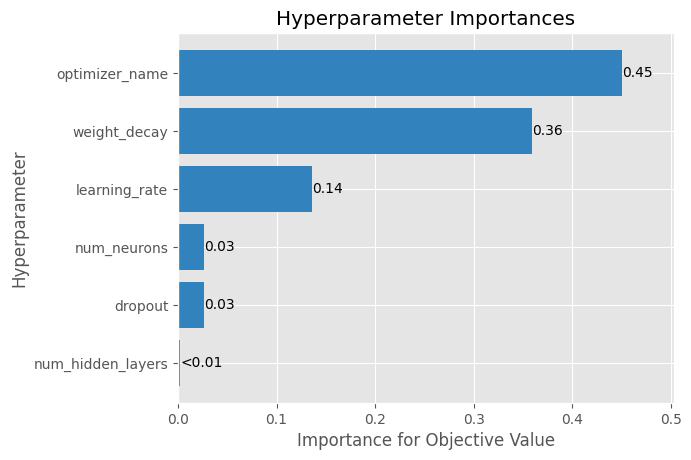

time: 324 ms (started: 2023-05-07 17:17:21 +00:00)


In [7]:
#shows the importance of each hyperparameter
fig = optuna.visualization.matplotlib.plot_param_importances(study)
fig

In [8]:
# Retrieve the best set of hyperparameters
best_params = study.best_params
print(best_params)

{'optimizer_name': 'AdamW', 'weight_decay': 0.002691190964084814, 'learning_rate': 0.0027759020319904943, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}
time: 684 µs (started: 2023-05-07 17:17:25 +00:00)


Concatenate the training and validation dataset into one final training set 

In [4]:
import os
import shutil

# Set the random seed for reproducibility
torch.manual_seed(42)

#this code combines both train and validation dataset into one training set, so we can use this to train the model on a larger dataset. 
train_dir = '/data/train'
val_dir = '/data/valid'

# Loop through the subdirectories in val_dir and move their files to train_dir
for class_dir in os.listdir(val_dir):
    src_class_dir = os.path.join(val_dir, class_dir)
    dst_class_dir = os.path.join(train_dir, class_dir)
        
    # Create the destination directory if it doesn't exist yet
    if not os.path.exists(dst_class_dir):
        os.makedirs(dst_class_dir)
        
    # Loop through the files in the source directory and move them to the destination directory
    for file in os.listdir(src_class_dir):
        src_file = os.path.join(src_class_dir, file)
        dst_file = os.path.join(dst_class_dir, file)
        shutil.move(src_file, dst_file)

# Remove the val_dir if it is empty
if not os.listdir(val_dir):
    os.rmdir(val_dir)

time: 60.5 ms (started: 2023-05-12 15:47:02 +00:00)


Use the imagefolder and dataloader function from Pytorch to preprocess and load the data to re-train the model on the final training set and evaluate on the test set, using the best obtained hyperparameter values during Hyperparameter tuning 

In [6]:
from torchvision import datasets, transforms
import torch.utils.data as data
from torch.utils.data import Subset

# Set the random seed for reproducibility
torch.manual_seed(42)

# Load and transform the data, apply data augmentation (Randaugment) only for the training set 
train_dataset = datasets.ImageFolder(root='data/train', transform=randaug_transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)

# load the data and shuffle the training data
train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True, num_workers=4)
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True,num_workers=4)

time: 49.7 ms (started: 2023-05-12 15:48:14 +00:00)


In [7]:
import timm 
#look up all the maxvit models in timm's library
repvgg_models = timm.list_models('*repvgg*')
repvgg_models

['repvgg_a2',
 'repvgg_b0',
 'repvgg_b1',
 'repvgg_b1g4',
 'repvgg_b2',
 'repvgg_b2g4',
 'repvgg_b3',
 'repvgg_b3g4']

time: 189 ms (started: 2023-05-12 15:48:15 +00:00)


Create the repvgg_b3 model from Timm's library

In [ ]:
#create the repvgg model
#The deep learning library called Timm was used to create the pre-trained models which has the weights pre-loaded. 
#A link to the github library is available at: https://github.com/huggingface/pytorch-image-models
#create model with new variable name and the best HP values to re-train the model 
import timm 
import torch
import torch.nn as nn

# Set the random seed for reproducibility
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
new_model = timm.create_model('repvgg_b3', pretrained=True, num_classes=8)

num_in_features = new_model.get_classifier().in_features

# Define the classification head with the best hyperparameter values
num_hidden_layers = 1
num_neurons = 512
dropout = 0.5
classifier_layers = []
for i in range(num_hidden_layers):
    if i == 0:
        in_features = num_in_features
        out_features = num_neurons
    else:
        in_features = num_neurons
        out_features = num_neurons
    classifier_layers.extend([
        nn.Linear(in_features, out_features),
        nn.BatchNorm1d(out_features),
        nn.Dropout(p=dropout),
    ])
classifier_layers.append(nn.Linear(num_neurons, 8))
new_model.head.fc = nn.Sequential(*classifier_layers)

#freeze the weights
for param in new_model.parameters():
    param.requires_grad = False
   
# unfreeze the last fc layer
for param in new_model.head.parameters():
    param.requires_grad = True

new_model.to(device)

In [9]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=new_model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ByobNet (ByobNet)                                  [32, 3, 224, 224]    [32, 8]              --                   Partial
├─RepVggBlock (stem)                               [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    └─ConvNormAct (conv_1x1)                      [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    │    └─Conv2d (conv)                          [32, 3, 224, 224]    [32, 64, 112, 112]   (192)                False
│    │    └─BatchNormAct2d (bn)                    [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ConvNormAct (conv_kxk)                      [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    │    └─Conv2d (conv)                          [32, 3, 224, 224]    [32, 64, 112, 112]   (1,728)              False
│    │    └─BatchNormAct2d (bn)   

time: 2.64 s (started: 2023-05-12 15:48:32 +00:00)


In [10]:
# define optimizers and loss function and use the best hyperparameters found during hyperparameter tuning
import torch.optim as optim

# Set the random seed for reproducibility
torch.manual_seed(42)

# define optimizers and loss function. 
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(new_model.parameters(), lr=0.0027759020319904943, weight_decay = 0.002691190964084814)

time: 1.23 ms (started: 2023-05-12 15:48:35 +00:00)


In [11]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

# Lists to store the loss and accuracy values
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Initialize variables for early stopping
best_test_loss = float('inf')
no_improvement_count = 0
epochs = 15
num_epochs = 15

# Train the model
for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    running_total = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            outputs = new_model(inputs)
            loss = criterion(outputs, labels)
            scaler.scale(loss).backward()    # Scale the gradients
            scaler.step(optimizer)           # Update the model parameters
            scaler.update()                  # Update the scaler

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        running_total += labels.size(0)
        running_corrects += (predicted == labels).sum().item()

    # Calculate the training loss and training accuracy
    train_loss = running_loss / len(train_dataloader.dataset)
    train_accuracy = 100 * running_corrects / running_total

    # evaluate on the test set
    new_model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    y_true = []
    y_scores = []
    y_pred = []
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = new_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += criterion(outputs, labels).item() * labels.size(0)

            # collect the predictions for the metrics calculation
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    # Calculate the test accuracy and test loss
    test_accuracy = 100 * correct / total
    test_loss /= len(test_dataloader.dataset)
  
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")
            
    # Save the loss and accuracy values
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)

Epoch 1/15: Train Loss: 1.2137, Train Acc: 58.6227, Test Loss: 1.0312, Test Acc: 62.5480
Epoch 2/15: Train Loss: 0.9947, Train Acc: 64.1628, Test Loss: 0.9742, Test Acc: 64.3899
Epoch 3/15: Train Loss: 0.9580, Train Acc: 64.9681, Test Loss: 0.9903, Test Acc: 66.5771
Epoch 4/15: Train Loss: 0.9398, Train Acc: 65.8790, Test Loss: 0.9400, Test Acc: 66.4620
Epoch 5/15: Train Loss: 0.9245, Train Acc: 66.5699, Test Loss: 0.9272, Test Acc: 65.8480
Epoch 6/15: Train Loss: 0.9168, Train Acc: 66.6271, Test Loss: 0.9192, Test Acc: 67.4981
Epoch 7/15: Train Loss: 0.8987, Train Acc: 67.2343, Test Loss: 0.9279, Test Acc: 66.5771
Epoch 8/15: Train Loss: 0.8957, Train Acc: 67.0187, Test Loss: 0.8925, Test Acc: 66.9992
Epoch 9/15: Train Loss: 0.8870, Train Acc: 67.6524, Test Loss: 0.8992, Test Acc: 66.5004
Epoch 10/15: Train Loss: 0.8778, Train Acc: 67.7404, Test Loss: 0.8784, Test Acc: 68.7260
Epoch 11/15: Train Loss: 0.8652, Train Acc: 68.2376, Test Loss: 0.8897, Test Acc: 67.1527
Epoch 12/15: Train 

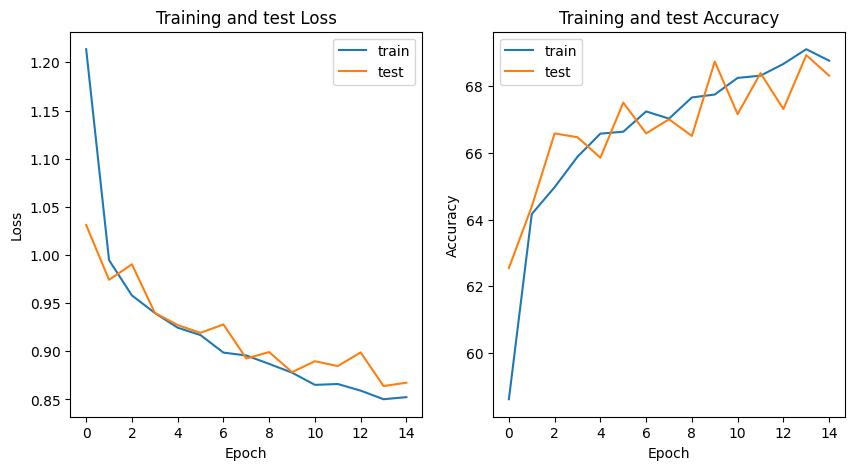

time: 411 ms (started: 2023-05-12 17:03:12 +00:00)


In [12]:
# Plot the training and testing loss and accuracy values
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and test Loss')
ax[0].legend()
ax[1].plot(train_accs, label='train')
ax[1].plot(test_accs, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy')
ax[1].legend()
plt.show()

In [14]:
# Calculate other metrics and the final test accuracy
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, classification_report
import pandas as pd
import numpy as np

import warnings
from sklearn.exceptions import UndefinedMetricWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(8)], digits=4)

conf_mat = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(np.array(pd.get_dummies(y_true)), y_scores, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Calculate other metrices
n_classes = conf_mat.shape[0]
tprs = []
specificity = 0
for i in range(n_classes):
    tp = conf_mat[i,i]
    fn = np.sum(conf_mat[i,:]) - tp
    fp = np.sum(conf_mat[:,i]) - tp
    tn = np.sum(conf_mat) - tp - fn - fp
    tpr = tp / (tp + fn)
    tprs.append(tpr)
sensitivity = np.mean(tprs)
test_accuracy /= 100

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(report)

Test Loss: 0.8674
Test Accuracy: 0.6830
Sensitivity: 0.3941
ROC-AUC: 0.8856
F1-score: 0.4216
Classification Report:
              precision    recall  f1-score   support

           0     0.4706    0.2697    0.3429        89
           1     0.5000    0.7942    0.6137       311
           2     0.5361    0.3225    0.4027       276
           3     0.0000    0.0000    0.0000        27
           4     0.6178    0.4778    0.5388       450
           5     0.7796    0.8784    0.8261      1349
           6     0.7143    0.1829    0.2913        82
           7     0.8333    0.2273    0.3571        22

    accuracy                         0.6830      2606
   macro avg     0.5565    0.3941    0.4216      2606
weighted avg     0.6723    0.6830    0.6604      2606

time: 35.6 ms (started: 2023-05-12 17:03:19 +00:00)


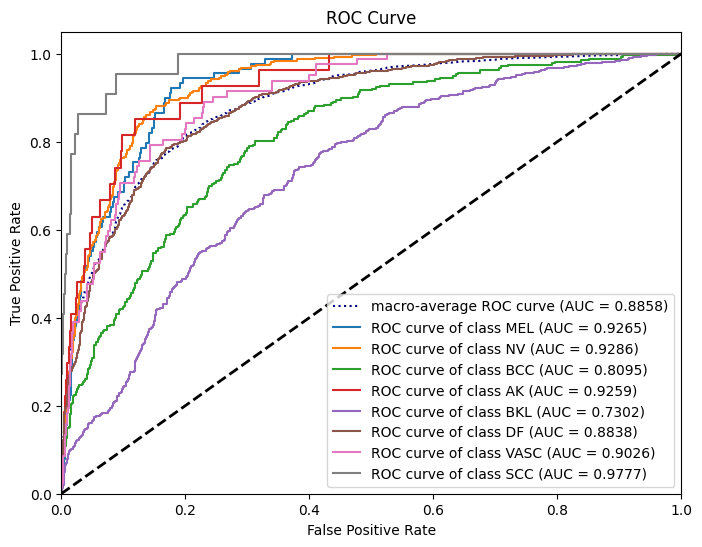

time: 308 ms (started: 2023-05-12 17:03:31 +00:00)


In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Convert the y_true and y_scores lists to arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_true))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (AUC = {0:0.4f})'.format(roc_auc["macro"]), color='navy', linestyle=':')

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.4f})'.format(class_dict[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

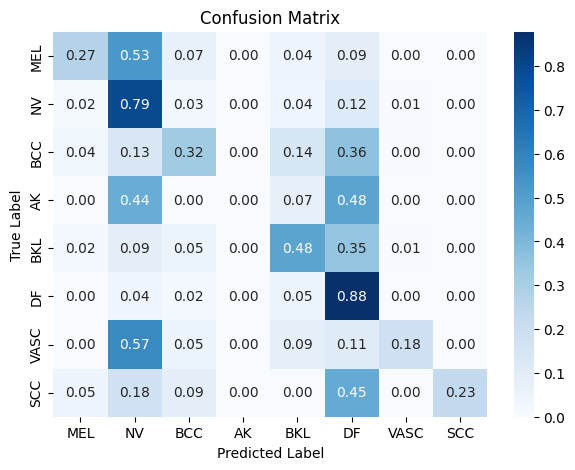

time: 417 ms (started: 2023-05-12 17:03:31 +00:00)


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(conf_mat / conf_mat.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
class_labels = sorted(list(class_dict.keys()), key=lambda x: int(x))
ax.xaxis.set_ticklabels([class_dict[label] for label in class_labels])
ax.yaxis.set_ticklabels([class_dict[label] for label in class_labels])
plt.show()

Reference to the specific libraries that were used in this code

• Ross Wightman. "PyTorch Image Models." GitHub repository. 2019. [Online]. Available: https://github.com/rwightman/pytorch-image-models.

• Takuya Akiba, Shotaro Sano, Toshihiko Yanase, Takeru Ohta, and Masanori Koyama. 2019. Optuna: A Next-generation Hyperparameter Optimization Framework. In KDD (arXiv).